In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

In [2]:
import influxdb
from src import influxdb_helper
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [1]:
HOST = 'localhost'
PORT = 8086

In [9]:
influxdb_helper = influxdb_helper.InfluxDB_Helper(HOST, PORT)

In [109]:
influxdb_helper.delete_db('user001')
influxdb_helper.create_db('user001')

Already exists: user001
Switched to db: user001
Dropped db: user001
Created db: user001


In [135]:
def csv_to_df_with_random_timeindex(filepath, delimiter, header=None, header_names=None):
    pd.set_option('display.max_colwidth', -1)
    pd.options.display.float_format = '{:.16g}'.format
    
    df = pd.read_csv(filepath, 
                     header=header, 
                     delimiter=delimiter, 
                     dtype=np.float64, 
                     names = header_names)
        
    rows = df.shape[0]
    date_today = datetime.now()
    days = pd.date_range(date_today, date_today + timedelta(milliseconds = rows - 1), freq='ms')    
    df_dates = pd.DataFrame(days, columns=['timestamp'])
    
    df = df.join(df_dates)
    df = df.set_index('timestamp')

    return df

In [111]:
input_data_dir = 'data/raw_data/'
filename = 'acc_exp01_user01.txt'

In [112]:
path = input_data_dir + filename
delimiter = " "
header_names = ["x", "y", "z"]
df = csv_to_df_with_random_timeindex(path, delimiter, header_names=header_names)

In [9]:
df.head()

,x,y,z
timestamp,,,
2019-04-22 09:57:13.049150,0.9180555898766518,-0.1124999994242935,0.5097222514293852
2019-04-22 09:57:13.050150,0.9111111304603812,-0.09305556168259388,0.5375000404706096
2019-04-22 09:57:13.051150,0.8819444981597608,-0.0861111144222878,0.5138889270791476
2019-04-22 09:57:13.052150,0.8819444981597608,-0.0861111144222878,0.5138889270791476
2019-04-22 09:57:13.053150,0.8791667143932526,-0.1000000028649177,0.5055555757796228


# Writing to influxdb

In [113]:
tags = {'user':'001', 'exp':'001'}
influxdb_helper.write_df(df, 'user001', 'accel', tags=tags)
user001_accel_df = influxdb_helper.get_db_meas_df('user001', 'accel')

# Getting from influxdb

In [81]:
def parse_groupby_dict(data, add_measurement=False):

    df_list = []

    for key, df in data.items():
        measurement, (tags) = key
        if add_measurement:
            df['measurement'] = measurement

        for tag in tags:
            name, value = tag
            df[name] = value

        df_list.append(df)
        
    return pd.concat(df_list)

In [95]:
df_client = influxdb_helper.get_client(df=True)
df_client.switch_database('user001')
query ='select * from "user001"."autogen"."accel" WHERE "user"=\'001\' LIMIT 50;'

# query ='SELECT * FROM "{0}"."autogen"."{1}" WHERE "exp"=\'{2}\' LIMIT 50;'.format('user001', 'accel', '001')
# query ='SELECT * FROM "{0}"."autogen"."{1}" WHERE "exp"=\'{2}\' LIMIT 50;'.format('user001', 'accel', '001')
query = "SELECT * FROM {}.autogen.{} " \
        "GROUP BY exp".format('user001', 'accel')
# query = 'select * from "user001"."autogen"."accel"'
result = df_client.query(query)
# result['accel'].describe()
label_df = parse_groupby_dict(result)
label_df.index = label_df.index.tz_convert('Asia/Tokyo')
label_df.head()

,user,x,y,z,exp
2019-04-22 18:57:13.049000+09:00,001,0.9180555898766518,-0.1124999994242935,0.5097222514293852,001
2019-04-22 18:57:13.050000+09:00,001,0.9111111304603812,-0.09305556168259388,0.5375000404706096,001
2019-04-22 18:57:13.051000+09:00,001,0.8819444981597608,-0.0861111144222878,0.5138889270791476,001
2019-04-22 18:57:13.052000+09:00,001,0.8819444981597608,-0.0861111144222878,0.5138889270791476,001
2019-04-22 18:57:13.053000+09:00,001,0.8791667143932526,-0.1000000028649177,0.5055555757796228,001


In [98]:
# rs = df_client.query("SELECT * FROM \"user001\".\"autogen\".\"accel\"")
# points = list(rs.get_points(measurement='accel', tags={'exp': '001'}))
# points
label_df.describe()

,x,y,z
count,20598,20598,20598
mean,0.88067318196875,-0.1017144366562462,0.09708831349410205
std,0.3464489542572221,0.3400909116671593,0.2855548233928689
min,-0.6472222561283949,-1.209722301873721,-0.6763889370528734
25%,0.8055555904523584,-0.2857638971813097,-0.0819444448505077
50%,0.9819445192586254,-0.2027777894963437,-0.004166666912662869
75%,1.01944450285877,-0.03194444645703996,0.2041666692236333
max,1.950000119684709,1.036111108210104,1.269444458358216


In [118]:
df_client = influxdb_helper.get_client(df=True)

query ='SELECT * FROM "{0}"."autogen"."{1}" WHERE "exp"=\'{2}\' LIMIT 500;'.format('user001', 'accel', '001')
result = df_client.query(query)
user001_accel_df = result['accel']
user001_accel_df.head()

,exp,user,x,y,z
2019-04-23 02:54:08.686000+00:00,001,001,0.9180555898766518,-0.1124999994242935,0.5097222514293852
2019-04-23 02:54:08.687000+00:00,001,001,0.9111111304603812,-0.09305556168259388,0.5375000404706096
2019-04-23 02:54:08.688000+00:00,001,001,0.8819444981597608,-0.0861111144222878,0.5138889270791476
2019-04-23 02:54:08.689000+00:00,001,001,0.8819444981597608,-0.0861111144222878,0.5138889270791476
2019-04-23 02:54:08.690000+00:00,001,001,0.8791667143932526,-0.1000000028649177,0.5055555757796228


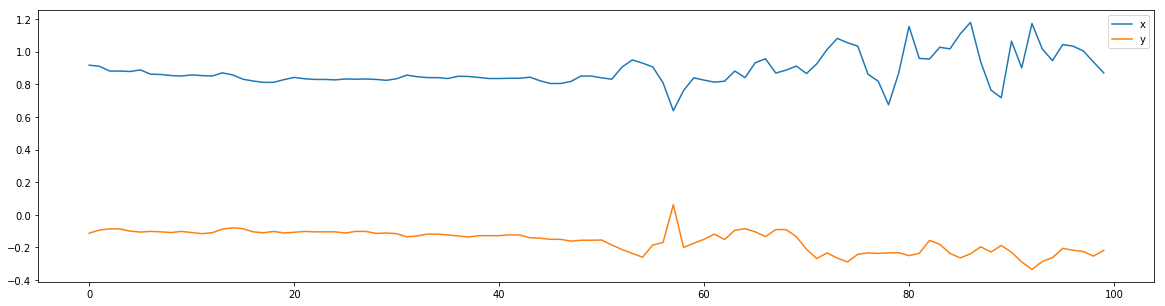

In [119]:
user001_accel_df = pd.DataFrame(user001_accel_df.values, columns=['exp', 'user', 'x', 'y', 'z'])
user001_accel_df[['x', 'y']][0:100].plot()

# PICKLING

In [44]:
import pickle
import zmq
import zlib
import blosc
import json
import time

def send_zipped_pickle(socket, obj, flags=0, protocol=-1):
    """pickle an object, and zip the pickle before sending it"""
    p = pickle.dumps(obj, protocol)
    z = blosc.compress(p, typesize=8)
    return socket.send(z, flags=flags)

current_milli_time = lambda: int(round(time.time() * 1000))

In [45]:
ZMQ_HOST = 'localhost'
ZMQ_PORT = 6000

In [46]:
user001_accel_df.mean(axis=0).x

0.8806731819687499

In [48]:
context = zmq.Context()

#  Socket to talk to server
print("Connecting to hello world server…")
socket = context.socket(zmq.REQ)
url = "tcp://{}:{}".format(ZMQ_HOST, ZMQ_PORT)
socket.connect(url)

sent_time = current_milli_time()
send_zipped_pickle(socket, user001_accel_df)
message = socket.recv_json()
json_rep = json.loads(message)
elapse_time = (json_rep["time"] - sent_time) / 1000

# Reading pandas series from a JSON
mean_series = pd.read_json(json_rep["mean"], typ='series', orient='records')
print("Received mean [ %s ] after [ %s ] seconds" % (mean_series['x'], elapse_time))

Connecting to hello world server…
Received mean [ 0.8806731820000001 ] after [ 14.808 ] seconds


# LEARNING HAPT FEAT_EXTRACTION

In [6]:
# input_data_dir = 'data/raw_data/'
# filename = 'acc_exp01_user01.txt'
# path = input_data_dir + filename

# tAcc_XYZ = np.loadtxt(path, delimiter=' ')
# tAcc_XYZ[0:5]

array([[ 0.91805559, -0.1125    ,  0.50972225],
       [ 0.91111113, -0.09305556,  0.53750004],
       [ 0.8819445 , -0.08611111,  0.51388893],
       [ 0.8819445 , -0.08611111,  0.51388893],
       [ 0.87916671, -0.1       ,  0.50555558]])

In [95]:
input_data_dir = 'data/raw_data/'
filename = 'acc_exp01_user01.txt'
path = input_data_dir + filename
delimiter = " "
header_names = ["x", "y", "z"]

df = csv_to_df_with_random_timeindex(path, delimiter, header_names=header_names)
df.values[0:5]
print(df.shape)

tAcc_XYZ = df.values

(20598, 3)


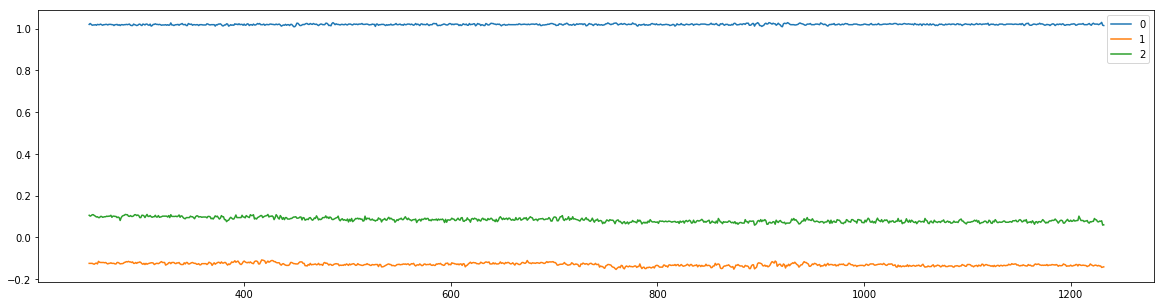

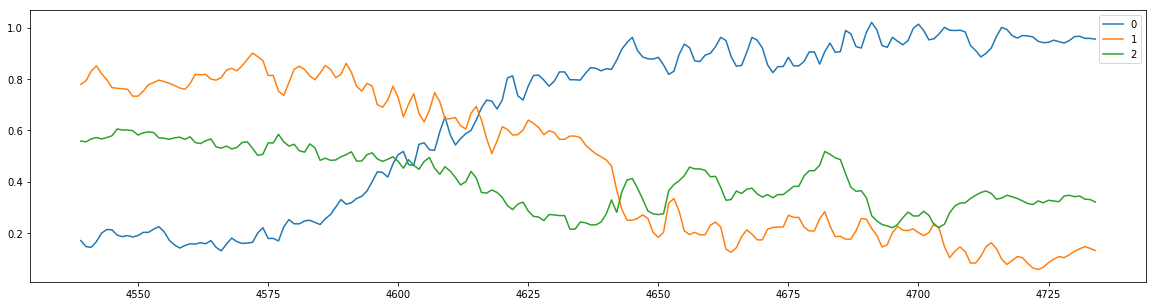

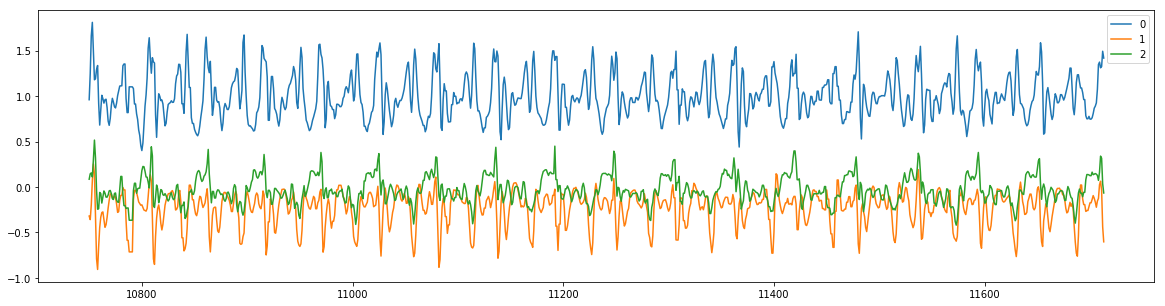

In [105]:
df = pd.DataFrame(df.values)
df[250:1233].plot()
df[4539:4735].plot()
df[10750:11714].plot()

In [6]:
from src import feature_extraction_separate
from src import feature_extraction

In [7]:
window = 128
slide = 64
fs =50.0
all_Acc_features = feature_extraction_separate.compute_all_Acc_features(tAcc_XYZ, window, slide, fs)
all_Acc_features.shape

(40, 320)

In [136]:
input_data_dir = 'data/raw_data/'
filename = 'gyro_exp01_user01.txt'
path = input_data_dir + filename
delimiter = " "
header_names = ["x", "y", "z"]

df = csv_to_df_with_random_timeindex(path, delimiter, header_names=header_names)
print(df.shape)

tGyr_XYZ = df.values

window = 128
slide = 64
fs =50.0
all_Gyr_features = feature_extraction_separate.compute_all_Gyr_features(tGyr_XYZ, window, slide, fs)
print('All Gyr feat shape:{}'.format(all_Gyr_features.shape))

(20598, 3)
All Gyr feat shape:(235, 320)


In [9]:
all_Acc_features.shape

(40, 320)

In [10]:
all_Gyr_features.shape

(235, 320)

# Online machine learning learning

In [37]:
import numpy as np
from sklearn import linear_model
n_samples, n_features = 1, 500
y = np.random.randn(n_samples)
X = np.random.randn(n_samples, n_features)
clf = linear_model.SGDRegressor()
import time
start_time = time.time()
clf.partial_fit(X, y)
elapsed_time = time.time() - start_time
print(elapsed_time)

0.00028228759765625


In [38]:
start_time = time.time()
y = np.random.randn(n_samples)
X = np.random.randn(n_samples, n_features)
clf.partial_fit(X, y)
elapsed_time = time.time() - start_time
print(elapsed_time)

0.0016298294067382812


In [43]:
a = np.asarray([[1, 2, 3, 4], [5, 6, 7, 8]])
print(a.shape)
a

(2, 4)


array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [41]:
b = np.asarray([[11, 22, 33, 44], [55, 66, 77, 88]])
print(b.shape)
b

array([[11, 22, 33, 44],
       [55, 66, 77, 88]])

In [45]:
c = np.hstack([a, b])
print(c.shape)
c.T

(2, 8)


array([[ 1,  5],
       [ 2,  6],
       [ 3,  7],
       [ 4,  8],
       [11, 55],
       [22, 66],
       [33, 77],
       [44, 88]])

# Importing all raw files into influxdb

In [133]:
def csv_to_df_with_random_timeindex(filepath, delimiter, header=None, header_names=None):
    pd.set_option('display.max_colwidth', -1)
    pd.options.display.float_format = '{:.16g}'.format
    
    df = pd.read_csv(filepath, 
                     header=header, 
                     delimiter=delimiter, 
                     dtype=np.float64, 
                     names = header_names)
        
    rows = df.shape[0]
    date_today = datetime.now()
    days = pd.date_range(date_today, date_today + timedelta(milliseconds = rows - 1), freq='ms')    
    df_dates = pd.DataFrame(days, columns=['timestamp'])
    
    df = df.join(df_dates)
    df = df.set_index('timestamp')

    return df

In [231]:
def write_with_tags(db, df, meas, tags=None):
#     tags = {'user':'001', 'exp':'001'}
    influxdb_helper.write_df(df, db, meas, tags=tags)
#     user001_accel_df = influxdb_helper.get_db_meas_df(db, meas)

In [12]:
HOST = 'localhost'
PORT = 8086
db_name = 'HAPT_DB'

In [273]:
import os, os.path
from src import influxdb_helper

influxdb_helper = influxdb_helper.InfluxDB_Helper(HOST, PORT)
influxdb_helper.delete_db(db_name)
influxdb_helper.create_db(db_name)

delimiter = " "
header_names = ["x", "y", "z"]

labels = 'data/raw_data/labels.txt'
mypath = 'data/raw_data'

# path joining version for other paths
no_of_files = (len([name for name in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, name))]))
print(no_of_files)

number_of_elements = no_of_files - 1

for i, filename in enumerate(sorted(os.listdir(mypath))):
    if filename == 'labels.txt':
        continue
    name_arr = filename.split("_")
    meas_type = name_arr[0]
    exp_no = name_arr[1][-2:]
    user_no = name_arr[2][4:6]
    print(meas_type, exp_no, user_no)
    path = mypath + '/' + filename
    df = csv_to_df_with_random_timeindex(path, 
                                         delimiter, 
                                         header_names=header_names)

    with open(labels) as f:
        for line in f:
            line_arr = line.split(" ")
            label_exp_no = line_arr[0]
            label_user_no = line_arr[1]
            act_no = int(line_arr[2])
            act_start = int(line_arr[3])
            act_end = int(line_arr[4])
            if len(label_exp_no) == 1:
                label_exp_no = '0' + label_exp_no
            if len(label_user_no) == 1:
                label_user_no = '0' + label_user_no
                
            if(exp_no == label_exp_no and user_no == label_user_no):
                df_slice = df[act_start:act_end]
                df_slice['label'] = act_no
                print(df_slice.shape)
                tags = {'user':user_no, 'exp':exp_no}
                write_with_tags(db_name, df_slice, meas_type, tags=tags)
#     break
    update_progress(i / number_of_elements)
update_progress(1)
print('Done')


Progress: [####################] 100.0%
Done


In [291]:
user001_accel_df = influxdb_helper.get_db_meas_df(db_name, 'acc')
print(user001_accel_df.shape)
display(user001_accel_df.head())

print(user001_accel_df.info(memory_usage='deep'))

(814400, 6)


,exp,label,user,x,y,z
2019-04-24 05:40:18.323000+00:00,01,5,01,1.020833394742025,-0.1250000020616516,0.105555564319952
2019-04-24 05:40:18.324000+00:00,01,5,01,1.025000070391787,-0.1250000020616516,0.1013888947481719
2019-04-24 05:40:18.325000+00:00,01,5,01,1.020833394742025,-0.1250000020616516,0.1041666724366978
2019-04-24 05:40:18.326000+00:00,01,5,01,1.016666719092262,-0.1250000020616516,0.1083333359304957
2019-04-24 05:40:18.327000+00:00,01,5,01,1.018055610975516,-0.1277777858281599,0.1083333359304957


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 814400 entries, 2019-04-24 05:40:18.323000+00:00 to 2019-04-24 05:43:19.152000+00:00
Data columns (total 6 columns):
exp      814400 non-null object
label    814400 non-null int64
user     814400 non-null object
x        814400 non-null float64
y        814400 non-null float64
z        814400 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 122.7 MB
None


In [311]:
user001_accel_df.groupby('label').count()
user001_accel_df['label'].value_counts()

5     137985
6     136745
4     126557
1     121964
2     116524
3     107775
11    14360 
9     12368 
10    11090 
12    10809 
7     10256 
8     7967  
Name: label, dtype: int64

# Plotting

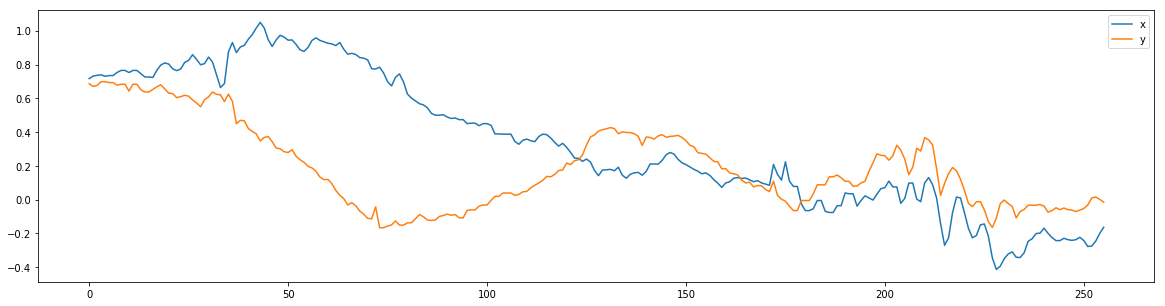

In [290]:
specific_act_df = pd.DataFrame(specific_act_df.values, columns=['label', 'exp', 'user', 'x', 'y', 'z'])
# specific_act_df[['x', 'y', 'z']][0:100].plot()
specific_act_df[['x', 'y', 'z']].plot()

# Utils

In [271]:
import time, sys
from IPython.display import clear_output
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)